In [1]:
# Topological Initialization for Multidimensional Scaling
# Melinda A. Kleczynski, Anthony J. Kearsley
# Finalized August 26, 2025 

# Data from: https://cave.cs.columbia.edu/repository/COIL-100

In [2]:
# Package versions 
# ----------------
# matplotlib                3.10.5
# numpy                     2.3.2
# oat_python                0.1.1
# pillow                    11.3.0
# scikit-bio                0.7.0
# scikit-learn              1.7.1
# scipy                     1.16.1

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from PIL import Image
from scipy.spatial.distance import pdist, squareform 
from skbio.stats.ordination import pcoa 
from sklearn.manifold import MDS 

import timds 

In [4]:
def read_image(object_number, image_index):

    fpath = 'coil-100\\obj' + str(object_number) + '__' + str(5*image_index) + '.png'  
    image = np.asarray(Image.open(fpath))   

    return image/np.max(image) 

In [5]:
n_images = 72

In [6]:
# images ordered by ground truth angle; shuffle to hide ground truth 
shuffled_image_indices = [i for i in range(n_images)] 
random.seed(0) 
random.shuffle(shuffled_image_indices) 

In [7]:
object_number = 29
example_name = 'Cat Food'
metric = 'cosine' 

In [8]:
images = [read_image(object_number, index) for index in shuffled_image_indices] 
image_data = np.vstack([image.flatten() for image in images]) 
image_pdist = squareform(pdist(image_data, metric = metric))

In [ ]:
### set up initial configurations 

# random initialization
m = n_images*(n_images-1)/2 
S = np.sum(np.square(image_pdist))/2  
sigma = (S/(4*m))**0.5
def get_random_init(seed = None):
    rng = np.random.default_rng(seed = seed)
    random_vals = rng.normal(size = (n_images, 2))
    random_init = sigma*random_vals
    return random_init 

# pcoa initialization 
pcoa_coords = pcoa(image_pdist, dimensions = 2, output_format = 'numpy').samples 

# topological initialization 
top_init_coords, bc1, cycle_diameter = timds.get_top(image_pdist) 
bc1 = bc1.sort_values(by = 'birth', ignore_index = True) 

In [10]:
# initial configurations

init_names = ['Random Seed 0', 
              'Random Seed 1', 
              'Random Seed 2', 
              'PCoA', 
              'Topological Initialization'] 

init_coords = [get_random_init(seed = 0), 
               get_random_init(seed = 1), 
               get_random_init(seed = 2),
               pcoa_coords,
               top_init_coords]

In [11]:
# run mds 

mds_coords = 5*[np.zeros(np.shape(pcoa_coords))]
mds_stresses = np.zeros(5) 
mds_iters = np.zeros(5, int)

for m in range(5):
 
    mds_alg = MDS(n_components = 2, dissimilarity = 'precomputed', n_init = 1, max_iter = 1000, eps = 1e-6)
    mds_coords[m] = mds_alg.fit_transform(image_pdist, init = init_coords[m])
    mds_stresses[m] = mds_alg.stress_ 
    mds_iters[m] = mds_alg.n_iter_ 

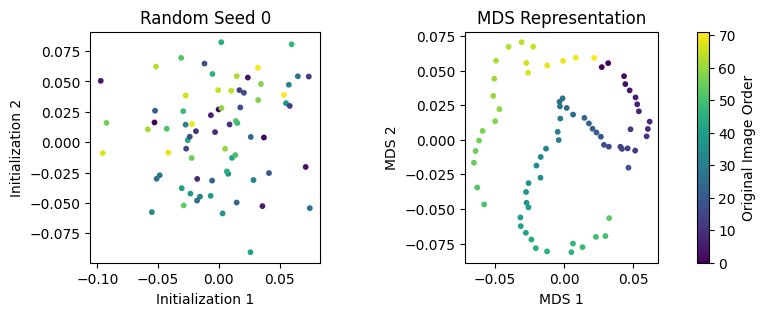

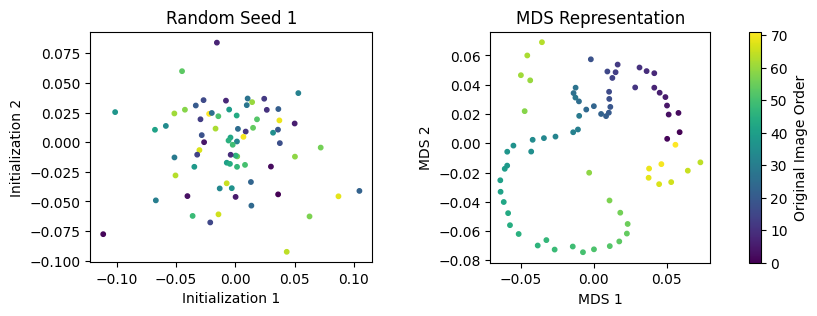

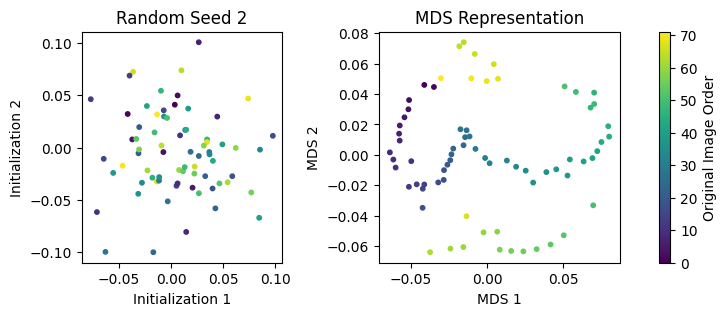

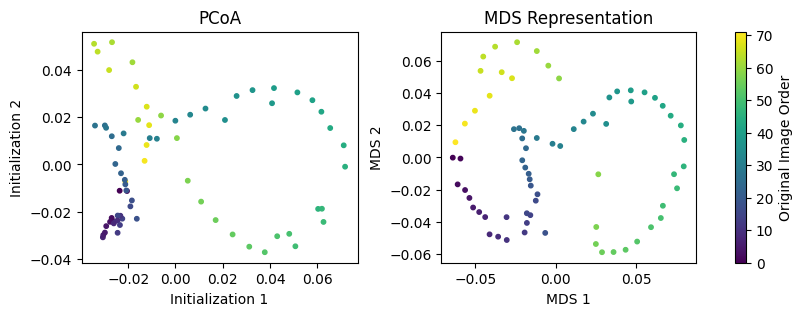

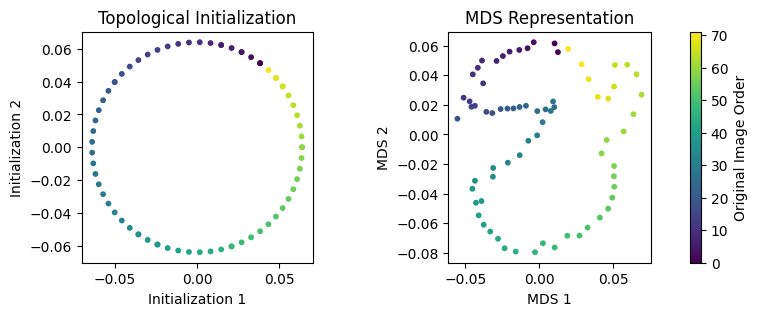

In [12]:
# plot 

for m in range(5): 

    fig, ax = plt.subplots(1, 2, figsize = (10, 3))

    ax[0].scatter(init_coords[m][:, 0], init_coords[m][:, 1], s = 10, c = shuffled_image_indices) 
    cbar_plt = ax[1].scatter(mds_coords[m][:, 0], mds_coords[m][:, 1], s = 10, c = shuffled_image_indices) 

    for i in range(2):
        ax[i].set_aspect('equal')
        
    cbar = plt.colorbar(cbar_plt, ax = ax)
    cbar.set_label('Original Image Order')

    ax[0].set_xlabel('Initialization 1') 
    ax[0].set_ylabel('Initialization 2')
    ax[0].set_title(init_names[m])
    
    ax[1].set_xlabel('MDS 1') 
    ax[1].set_ylabel('MDS 2')
    ax[1].set_title('MDS Representation')

plt.show()

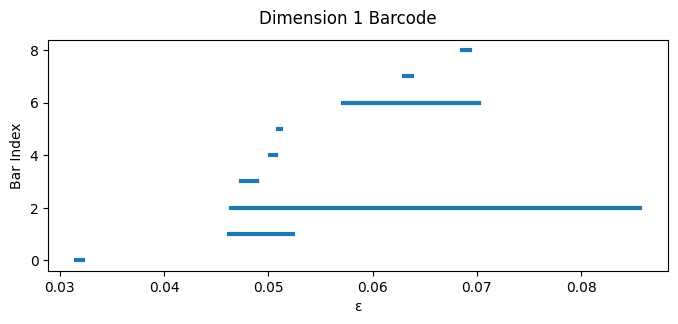

In [13]:
fig, ax = plt.subplots(figsize = (8, 3))

for bar_iter in range(len(bc1)):
    ax.plot(bc1.iloc[bar_iter], [bar_iter, bar_iter], color = 'tab:blue', lw = 3)

ax.set_xlabel('ε') 
ax.set_ylabel('Bar Index')
plt.suptitle('Dimension 1 Barcode')

plt.show()

In [14]:
for m in range(5):

    print(init_names[m], mds_iters[m], '%.2e' %mds_stresses[m])

Random Seed 0 247 1.09e+00
Random Seed 1 173 1.22e+00
Random Seed 2 101 1.30e+00
PCoA 90 9.80e-01
Topological Initialization 68 1.02e+00


In [15]:
mpc_edges = timds.get_mpc_edges(image_pdist)[0]
len(np.unique(mpc_edges))

61